In [2]:
import pandas as pd
import json
import re
import numpy as np
import os

Results were collected between 11.06. -- 23.07.2021

Prior to parsing, spurious responses were discarded on the basis of:

* All extreme values
* Inappropriate comments
* Non-target user profile (userProfiling_position == 'other')

## Data parsing

In [3]:
# Loading Data
RESULTS_FILEPATH = "data/20210723094949_results.json"
figure_save_dir = os.path.splitext(RESULTS_FILEPATH)[0]

ids_to_exclude = [
    "1624013360083", #inappropriate comment, extreme values
    "1623688924533", #test input
    ]

with open(RESULTS_FILEPATH) as f:
    # remove image0/image1 vars since it prevents proper df merging
    text = f.read()
    text = re.sub(r"_image[0-3]", "", text)
    text = re.sub(r"user_profiling_", "user_", text)
    text = re.sub(r"user_", "userProfiling_", text)
    lines = text.splitlines()
    data = []
    for line in lines[1:-1]:
        entry = json.loads(line)
        entry["id"] = str(round(entry["id"]))
        if "userProfiling_aiFamiliarity" not in entry['userProfiling_'].keys():
            entry["userProfiling_"]["userProfiling_aiFamiliarity"]="missing"
        data.append(entry)
    df = pd.json_normalize(data)
    df.drop(labels=["__v", "_id.$oid"], axis=1, inplace=True)

renamed = [name.split("_.")[-1] for name in df.columns]
col_rename = {i: j for i, j in zip(df.columns, renamed)}
df = df.rename(columns=col_rename)
df.drop_duplicates(subset=['id'], inplace=True)

df = df[~df.id.isin(ids_to_exclude)]
df = df[df.userProfiling_position != "other"]
df.set_index("id", inplace=True)
df



,userProfiling_age,userProfiling_position,userProfiling_useOfAI,userProfiling_useOfDP,userProfiling_mlFamiliarity,userProfiling_aiFamiliarity,saliencyMaps_globalSaliency_understandability,saliencyMaps_globalSaliency_usability,saliencyMaps_globalSaliency_informativeness,saliencyMaps_globalSaliency_value,...,trustScores_borderlineCases_value,userProfiling_useOfAI_details,saliencyMaps_globalSaliency_comments,saliencyMaps_localSaliency_comments,conceptAttribution_textAttributes_comments,trustScores_borderlineCases_comments,userProfiling_comments,counterfactuals_twoAxisCounterfactuals_comments,counterfactuals_prototypeInterpolation_comments,userProfiling_position-Comment
id,,,,,,,,,,,,,,,,,,,,,
1623319499818,30-40,Assisting physician (Assistenzarzt) for pathol...,in routine diagnostics,in routine diagnostics,1,missing,5,5,6,6,...,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1623330321488,41-50,Researcher in pathology/neuropathology,in research,in research,3,missing,7,7,7,7,...,3,"from MindPeak (BreastIHC), from VMscope (Cogni...",There is one cell slightly to the right of the...,Per-cell saliency is probably too much detail.,This is excellent but I think there could be q...,High confidence should provide examples of bot...,NaN,NaN,NaN,NaN
1623391402856,30-40,Researcher in pathology/neuropathology,[in research],[in research],7,5,6,3,4,5,...,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1623391916479,41-50,Technician (MTA) for pathology/neuropathology,[in routine diagnostics],[in research],7,4,5,7,3,6,...,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1623439901422,30-40,Trainee (Assistenzarzt) in pathology/neuropath...,[in research],[in research],2,5,4,5,6,4,...,5,QuPath immunohistochemistry positive cell dete...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1623441394465,30-40,Consultant (Facharzt) for pathology/neuropatho...,[in research],[in research],7,7,6,5,5,6,...,5,Aiforia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1623655000204,51-60,Researcher in pathology/neuropathology,[none],[none],2,3,5,5,5,5,...,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1623674498302,41-50,Consultant (Facharzt) for pathology/neuropatho...,[none],[in routine diagnostics],4,5,1,1,1,1,...,2,NaN,NaN,NaN,NaN,Confidence for what? positive or negative or b...,NaN,NaN,NaN,NaN
1623676868025,41-50,Consultant (Facharzt) for pathology/neuropatho...,[none],[none],5,5,3,3,2,2,...,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
user_df = df[
    [
        "userProfiling_age",
        "userProfiling_position",
        "userProfiling_useOfDP",
        "userProfiling_useOfAI",
        "userProfiling_useOfAI_details",
        "userProfiling_mlFamiliarity",
        "userProfiling_aiFamiliarity"
    ]
]

fields = ["Understandability", "Usability", "Informativeness", "Value"]

instance_identifiers = {
    "Counterfactuals: Single axis": "counterfactuals_prototypeInterpolation",
    "Counterfactuals: Two axes": "counterfactuals_twoAxisCounterfactuals",
    "Saliency Maps: Local": "saliencyMaps_localSaliency",
    "Saliency Maps: Global": "saliencyMaps_globalSaliency",
    "Concept Attribution: Text": "conceptAttribution_textAttributes",
    "Prototypes: Highest confidence": "prototypes_prototypes",
    "Trust Scores: Borderline Cases": "trustScores_borderlineCases",
}

result_dataframes = dict()
comments = dict()
for name, id_ in instance_identifiers.items():
    result_dataframes[name] = df[[f"{id_}_{field.lower()}" for field in fields]]
    result_dataframes[name].columns = fields

    comments_column = f"{id_}_comments"
    if comments_column in df.columns:
        comments[name] = df[[comments_column]].dropna().values.squeeze(axis=1).tolist()
    else:
        comments[name] = []

result_dataframes["Counterfactuals: Single axis"]


,Understandability,Usability,Informativeness,Value
id,,,,
1623319499818,6,6,7,6
1623330321488,7,7,7,7
1623391402856,4,6,4,5
1623391916479,6,4,5,5
1623439901422,3,2,2,1
1623441394465,7,7,7,7
1623655000204,2,2,2,2
1623674498302,7,4,6,5
1623676868025,5,6,5,5


In [5]:
comments

{'Counterfactuals: Single axis': ["Like previous, initial reaction is that interpolation is useful but doesn't give the full picture of possible negatives. Perhaps clicking around each cell and seeing the interpolation for each would feel more useful",
  'What is a counterfactual? '],
 'Counterfactuals: Two axes': ['It seems there may be many counterfactual examples that are more closely related to the positive example which could be useful for understanding the nuances and building trust',
  'Do not understand this question'],
 'Saliency Maps: Local': ['Per-cell saliency is probably too much detail. '],
 'Saliency Maps: Global': ['There is one cell slightly to the right of the center that is labeled as positive and is quite darkly stained by IHC, but does not show up on the saliency map, which is a bit surprising. It looks like an endothelial cell. '],
 'Concept Attribution: Text': ['This is excellent but I think there could be quite a lot of additional factors, so this would need som

## Overall comparison

## Stacked diverging bar charts

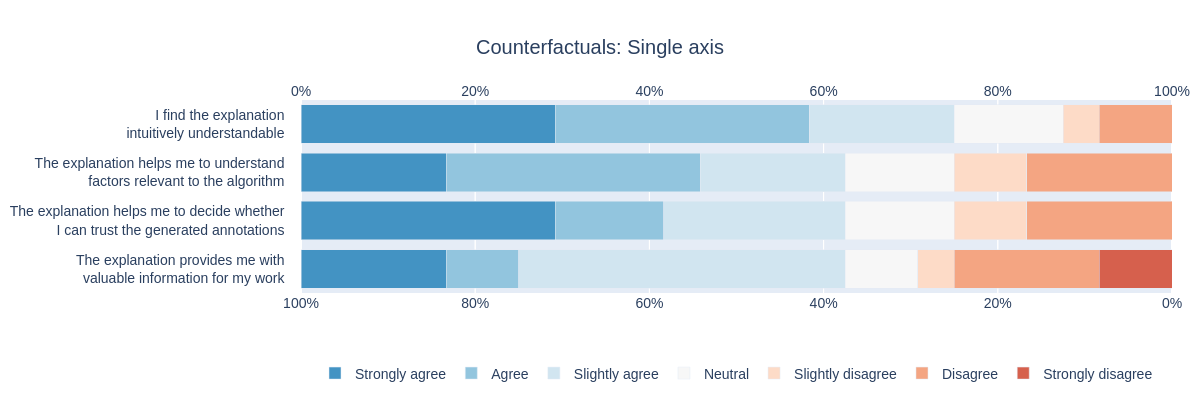

Like previous, initial reaction is that interpolation is useful but doesn't give the full picture of possible negatives. Perhaps clicking around each cell and seeing the interpolation for each would feel more useful
What is a counterfactual? 


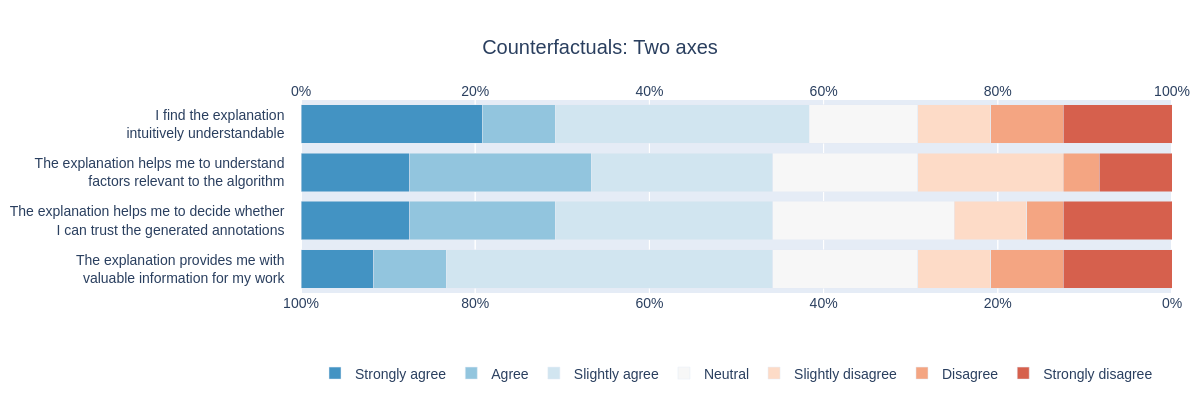

It seems there may be many counterfactual examples that are more closely related to the positive example which could be useful for understanding the nuances and building trust
Do not understand this question


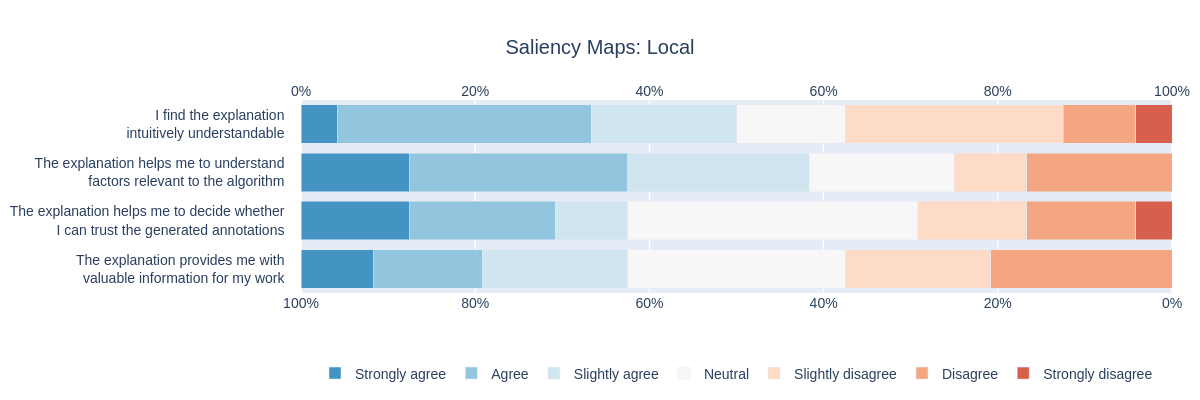

Per-cell saliency is probably too much detail. 


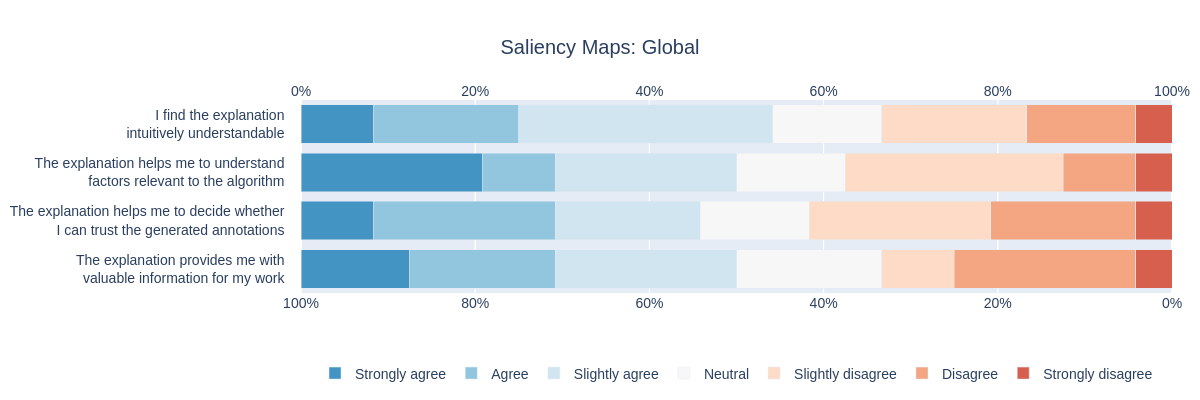

There is one cell slightly to the right of the center that is labeled as positive and is quite darkly stained by IHC, but does not show up on the saliency map, which is a bit surprising. It looks like an endothelial cell. 


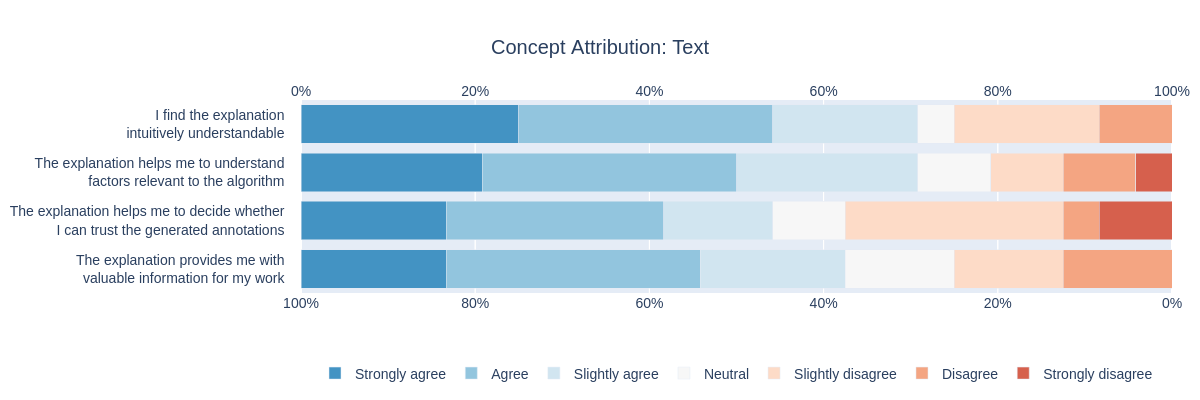

This is excellent but I think there could be quite a lot of additional factors, so this would need some supervision. 


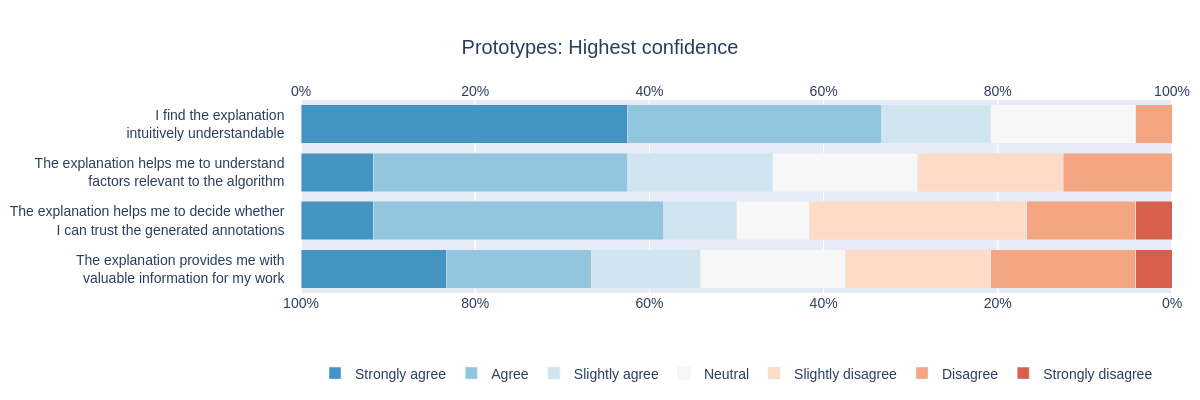

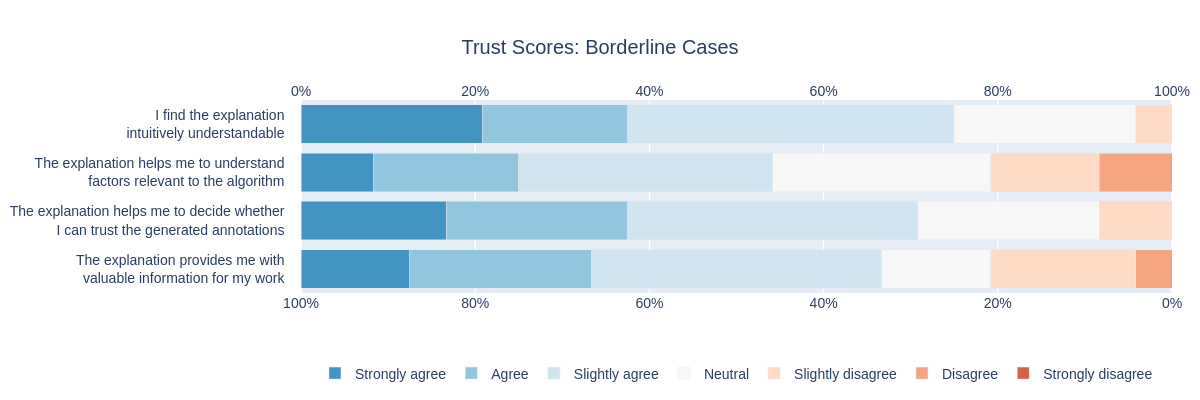

High confidence should provide examples of both classes (pos. and neg.), no? 
Confidence for what? positive or negative or both?
I felt I needed the pos or neg labels in addition to the confidence


In [86]:
from typing import Optional
from collections import Counter

import plotly
import plotly.graph_objects as go
import plotly.express as px

from PIL import Image
import io
from IPython.display import display

def plotly_figure_to_image(fig, extension: str = 'png', **kwargs):
    img_bytes = fig.to_image(format=extension, **kwargs)
    return Image.open(io.BytesIO(img_bytes))

def save_image(image, name: str, save_dir: str = "images", extension: str="png"):
    if not os.path.exists(save_dir):
        os.mkdir(save_dir)
    filename = "".join(i for i in name if i not in "\\/:*?<>| ")
    filepath = f"{save_dir}/{filename}.{extension}"
    image.save(filepath)

def stackedBarChartDF(
    df: pd.DataFrame,
    title: str,
    palette: list,
    diverging: bool = False,
    attributes: list = ["Understandability", "Usability", "Informativeness", "Value"],
    labels: Optional[list] = None,
    save_fig: bool = False,
    save_dir: str = "images",
    width: int = 1200,
    height: int = 400,
    font: dict = {'size' : 14},
    web_display: bool = False
):
    counters = [Counter(df[attribute]) for attribute in attributes]

    fig = go.Figure()  # type: ignore

    category_order = [
        "Strongly disagree",
        "Disagree",
        "Slightly disagree",
        "Neutral",
        "Slightly agree",
        "Agree",
        "Strongly agree",
    ]

    number_order = [1, 2, 3, 4, 5, 6, 7]

    labels = labels if labels else attributes

    def add_bar_trace(num, transform, showlegend: bool = True):
        rating = number_order[num]
        counts = [counter[rating] for counter in counters]
        total_count = sum(counters[0].values())

        xvals = [transform(count) / total_count for count in counts]

        fig.add_trace(
            go.Bar(
                x=xvals,
                y=labels,
                orientation="h",
                name=category_order[num],
                width=0.8,
                marker_color=palette[num],
                legendgroup=category_order[num],
                showlegend=False,

            )  # type: ignore
        )

    if diverging:
        # negative side
        add_bar_trace(3, lambda x: x * -0.5)
        for num in reversed(range(0, 3)):
            add_bar_trace(num, lambda x: x * -1)

        # positive side
        add_bar_trace(3, lambda x: x * 0.5, showlegend=False)
        for num in range(4, 7):
            add_bar_trace(num, lambda x: x)
    else:
        for num in reversed(range(0,7)):
            add_bar_trace(num, lambda x: x)
    

    for num in reversed(range(0, 7)):
            fig.add_trace(
                go.Bar(
                    x=[0] * 7,
                    y=labels,
                    orientation="h",
                    name=category_order[num],
                    marker_color=palette[num],
                    legendgroup=category_order[num]
                )  # type: ignore
            )

    fig.update_layout(
        barmode="relative" if diverging else "stack",
        yaxis_autorange="reversed",
        title=dict(
            text=title,
            x=0.5,
            y=0.9
            ),
        xaxis={"tick0": 0, "tickformat": "%", "range": [-1, 1]},
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=-0.5,
            xanchor="center",
            x=0.5,
        ),
        font=font,
        autosize=True,
        margin=dict(
            r=10,
            l=10
        )
    )

    if not diverging:
        fig.update_layout(
            xaxis = {
                "range" : [0,1],
                'side': 'top'
                # "color" : palette[-1]
                }, 
            xaxis2= {
                'anchor': 'y', 
                'overlaying': 'x', 
                'side': 'bottom', 
                "tickformat": "%", 
                "range": [1, 0], 
                # "color" : palette[1]
                })
        fig.data[-1].update(xaxis='x2')

    im = plotly_figure_to_image(fig, width=width, height=height, validate=True)
    
    if web_display: 
        fig.show()
    else:
        display(im)

    if save_fig:
        save_image(im, name, save_dir)

    return fig, counters


palette = [plotly.colors.diverging.RdBu[n] for n in [2, 3, 4, 5, 6, 7, 8]]  # type: ignore
space = " " * 4
labels = [
    f"I find the explanation{space}<br>intuitively understandable{space}",
    f"The explanation helps me to understand{space}<br>factors relevant to the algorithm{space}",
    f"The explanation helps me to decide whether{space}<br> I can trust the generated annotations{space}",
    f"The explanation provides me with{space}<br>valuable information for my work{space}",
]

counters = []

for name, df in result_dataframes.items():
    fig, counter = stackedBarChartDF(
        df,
        name,
        palette,
        labels=labels,
        web_display=False,
        save_fig=True,
        save_dir=figure_save_dir,
        font={'size':14},
        width=1200,
        height=400
    )

    px.imshow(df.corr(method='spearman'), zmin=0, width = 500, height=300).show()

    for comment in comments[name]:
        print(comment)
    counters.append(counter) 

In [7]:
labels = [
    f"I find the explanation intuitively understandable",
    f"The explanation helps me to understand factors relevant to the algorithm",
    f"The explanation helps me to decide whether I can trust the generated annotations",
    f"The explanation provides me with valuable information for my work",
]

for name, df in result_dataframes.items():
    print(name)
    for index, column in enumerate(df.columns):
        percentage_agree = df[df[column] > 4][column].count() / df[column].count()
        percentage_stronglyagree = df[df[column] > 5][column].count() / df[column].count()

        percentage_disagree = df[df[column] < 4][column].count() / df[column].count()
        percentage_stronglydisagree = df[df[column] < 3][column].count() / df[column].count()
        print(
            '\t', labels[index], "\n\t\t", 
            '{:.0%}'.format(percentage_stronglydisagree), " disagree or strongly disagree", " | ",
            '{:.0%}'.format(percentage_disagree), " disagree", " | ", 
            '{:.0%}'.format(percentage_agree), " agree", " | "
            '{:.0%}'.format(percentage_stronglyagree), " agree or strongly agree")

Counterfactuals: Single axis
	 I find the explanation intuitively understandable 
		 8%  disagree or strongly disagree  |  12%  disagree  |  75%  agree  | 58%  agree or strongly agree
	 The explanation helps me to understand factors relevant to the algorithm 
		 17%  disagree or strongly disagree  |  25%  disagree  |  62%  agree  | 46%  agree or strongly agree
	 The explanation helps me to decide whether I can trust the generated annotations 
		 17%  disagree or strongly disagree  |  25%  disagree  |  62%  agree  | 42%  agree or strongly agree
	 The explanation provides me with valuable information for my work 
		 25%  disagree or strongly disagree  |  29%  disagree  |  62%  agree  | 25%  agree or strongly agree
Counterfactuals: Two axes
	 I find the explanation intuitively understandable 
		 21%  disagree or strongly disagree  |  29%  disagree  |  58%  agree  | 29%  agree or strongly agree
	 The explanation helps me to understand factors relevant to the algorithm 
		 12%  disagree or 

In [67]:
import plotly.express as px

from typing import Callable, Optional

dfFilter = Optional[Callable[[pd.DataFrame], pd.DataFrame]]

def boxPlotDF(
    df: pd.DataFrame,
    title: str,
    palette: list,
    filter_neg: dfFilter = None,
    filter_pos: dfFilter = None,
    save_fig: bool = False,
    save_dir: str = "images",
    width:int = 1200,
    height:int = 400,
    font: dict = {'size' : 14},
    web_display: bool = False,
    **kwargs
):
    explanation_classes = [
        "Counterfactuals",
        "Saliency Maps",
        "Concept Attribution",
        "Prototypes",
        "Trust Scores",
    ]

    instances = [
    "Counterfactuals: Single axis",
    "Counterfactuals: Two axes",
    "Saliency Maps: Local",
    "Saliency Maps: Global",
    "Concept Attribution: Text",
    "Prototypes: Highest confidence",
    "Trust Scores: Borderline Cases"
    ]

    color_dict = {
        explanation_class: palette[idx]
        for idx, explanation_class in enumerate(explanation_classes)
    }

    sorted_index = df[[column for column in instances]].median(axis=0).sort_values(ascending=False).index
    results_only_df = df[sorted_index]

    fig = go.Figure()  # type: ignore
    for column in results_only_df:
        split_column = column.split(": ")
        explanation_class = split_column[0]
        column_name = f"{explanation_class}:<br>{split_column[1]}"
        fig.add_trace(
            go.Violin(
                y=df[column][filter_neg(df)] if filter_neg else df[column],
                name=column_name,
                box_visible=True,
                marker_color=color_dict[explanation_class],
                legendgroup=explanation_class,
                showlegend=False,
                side="negative" if filter_pos else "both",
            )  # type: ignore
        )
        if filter_pos:
            fig.add_trace(
            go.Violin(
                y=df[column][filter_pos(df)],
                name=column_name,
                box_visible=True,
                marker_color=color_dict[explanation_class],
                legendgroup=explanation_class,
                showlegend=False,
                side="positive",
            )  # type: ignore
        )

    if kwargs:
        fig.update_traces(**kwargs)

    # Legend
    for explanation_class in explanation_classes:
        fig.add_trace(
            go.Violin(
                y=[None],
                name=explanation_class,
                marker_color=color_dict[explanation_class],
                legendgroup=explanation_class,
                showlegend=True,
            )  # type: ignore
        )

    fig.update_layout(
        title=dict(
            text=title,
            x=0.5,
            y=0.9),
        yaxis=dict(dtick=1),
        yaxis_range=[1, 7],
        yaxis_title="Average Rating Response",
        showlegend=True,
        font=font
    )
    )

    im = plotly_figure_to_image(fig, width=width, height=height)
    
    if web_display: 
        fig.show()
    else:  
        display(im)

    if save_fig:
        save_image(im, title, save_dir)


aggregated_df = pd.DataFrame()
for name, df in result_dataframes.items():
    aggregated_df[name] = df.mean(axis=1)

full_df = user_df.join(aggregated_df)

boxPlotDF(
    full_df, "Comparison of Average Rating Response", 
    plotly.colors.qualitative.Vivid, # type: ignore
    save_fig=False,
    save_dir=figure_save_dir,
    web_display=True,
    scalemode='count'
    ) #type: ignore


boxPlotDF(
    full_df, "Comparison of Average Rating Response (consultants only)", 
    plotly.colors.qualitative.Vivid, # type: ignore
    filter_neg=lambda df: df.userProfiling_position.str.startswith("Consultant"),
    web_display=True,
    scalemode='count'
    )


In [62]:
attributes = ["Understandability", "Usability", "Informativeness", "Value"]
for index, attribute in enumerate(attributes):
    aggregated_df = pd.DataFrame()
    for name, df in result_dataframes.items():
        aggregated_df[name] = df[attribute]

    boxPlotDF(
        user_df.join(aggregated_df), labels[index], 
        plotly.colors.qualitative.Vivid, # type: ignore
        web_display=True
        )  

## User profiling

In [10]:
new_user_df = user_df.copy()
new_user_df.columns = [column.split("_")[1] for column in user_df.columns]
new_user_df

,age,position,useOfDP,useOfAI,useOfAI,mlFamiliarity,aiFamiliarity
id,,,,,,,
1623319499818,30-40,Assisting physician (Assistenzarzt) for pathol...,in routine diagnostics,in routine diagnostics,NaN,1,missing
1623330321488,41-50,Researcher in pathology/neuropathology,in research,in research,"from MindPeak (BreastIHC), from VMscope (Cogni...",3,missing
1623391402856,30-40,Researcher in pathology/neuropathology,[in research],[in research],NaN,7,5
1623391916479,41-50,Technician (MTA) for pathology/neuropathology,[in research],[in routine diagnostics],NaN,7,4
1623439901422,30-40,Trainee (Assistenzarzt) in pathology/neuropath...,[in research],[in research],QuPath immunohistochemistry positive cell dete...,2,5
1623441394465,30-40,Consultant (Facharzt) for pathology/neuropatho...,[in research],[in research],Aiforia,7,7
1623655000204,51-60,Researcher in pathology/neuropathology,[none],[none],NaN,2,3
1623674498302,41-50,Consultant (Facharzt) for pathology/neuropatho...,[in routine diagnostics],[none],NaN,4,5
1623676868025,41-50,Consultant (Facharzt) for pathology/neuropatho...,[none],[none],NaN,5,5


In [11]:
pd.set_option('display.max_colwidth', None)
px.histogram(new_user_df['position'].replace(
    {
        "Assisting physician (Assistenzarzt) for pathology/neuropathology" : "Trainee",
        "Trainee (Assistenzarzt) in pathology/neuropathology" : "Trainee",
        "Trainee (Assistenzärztin*arzt) in pathology/neuropathology" : "Trainee",
        "Consultant (Facharzt) for pathology/neuropathology" : "Consultant",
        "Consultant (Fachärztin*arzt) for pathology/neuropathology" : "Consultant",
        "Researcher in pathology/neuropathology" : "Researcher",
        "Technician (MTA) for pathology/neuropathology" : "Technician"
    }
)).update_xaxes(categoryorder="total descending")

In [12]:
px.histogram(new_user_df['age'])